### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarising the Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html


In [2]:
df = pd.read_excel(r"C:\Users\ruthf\OneDrive\Documents\Data Immersion\Achievement 6\Project\02 Data\1. Orignal Data\StockX_data_add_columns.xlsx")

In [3]:
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Profit,Profit %,Release Year,Sold Year,Days since release
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California,877.0,3.986364,2016,2017,342
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California,465.0,2.113636,2016,2017,282
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California,470.0,2.136364,2016,2017,282
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky,855.0,3.886364,2016,2017,282
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island,608.0,2.763636,2017,2017,202


## 2. Subsetting, wrangling, and cleaning time-series data

There is no need to subset the data as we only have sales for Sept 2017 to Feb 2019 it is not a large time period.

In [4]:
# agg sale data by day
df2 = df.groupby('Order Date').agg({'Sale Price':['sum']})

In [5]:
df2.columns

MultiIndex([('Sale Price', 'sum')],
           )

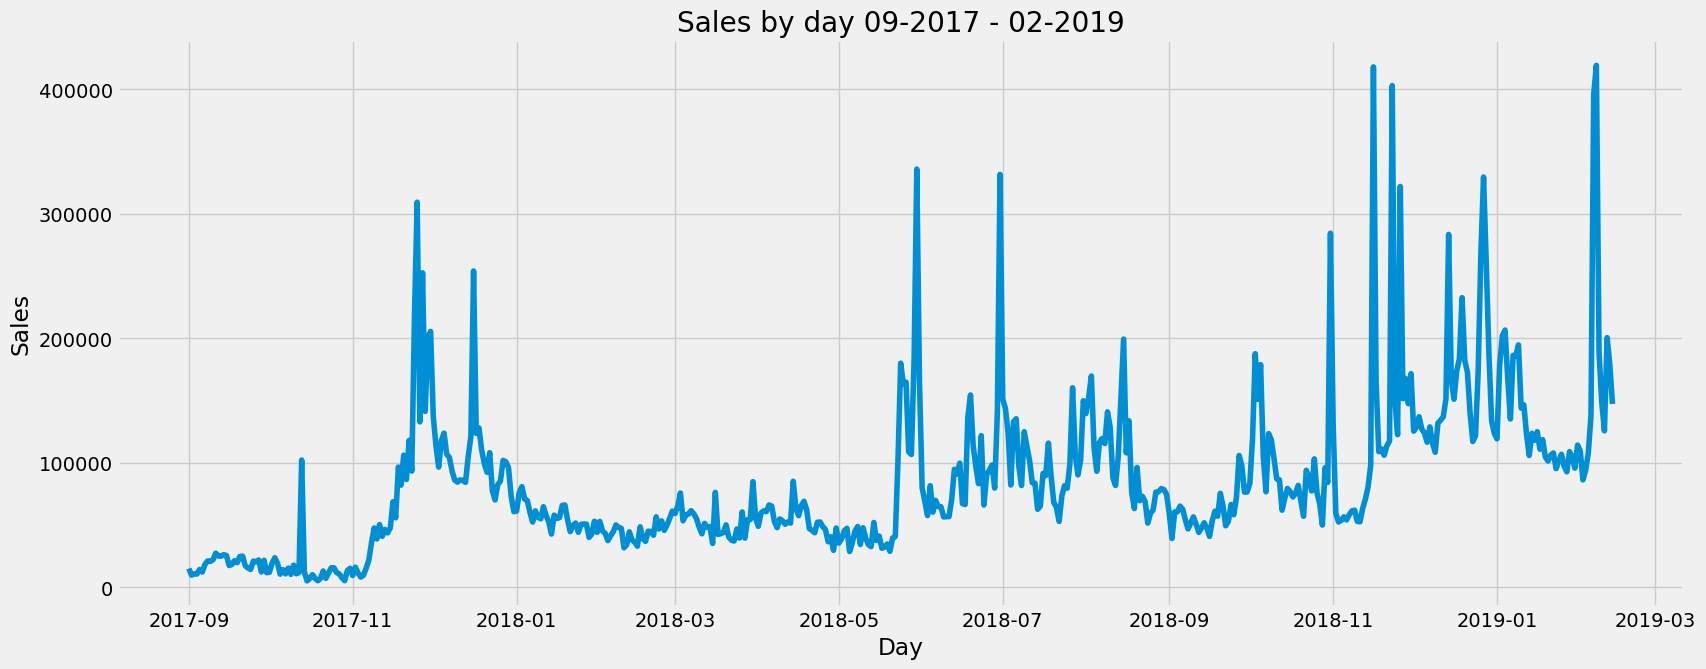

In [6]:
plt.figure(figsize=(18,7), dpi=100) 
plt.title('Sales by day 09-2017 - 02-2019')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.plot(df2)

In [7]:
df2.head()

,Sale Price
,sum
Order Date,
2017-09-01,15019.0
2017-09-02,9744.0
2017-09-03,10759.0
2017-09-04,10604.0
2017-09-05,14273.0


In [8]:
# Check for missing values (you shouldn't have any)

df2.isnull().sum() 

Sale Price  sum    0
dtype: int64

In [9]:
# Check for duplicates

dups = df2.duplicated()
dups.sum()

# No dups!

0

### 3. Time series analysis: decomposition

In [10]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df2, model='additive')

In [11]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

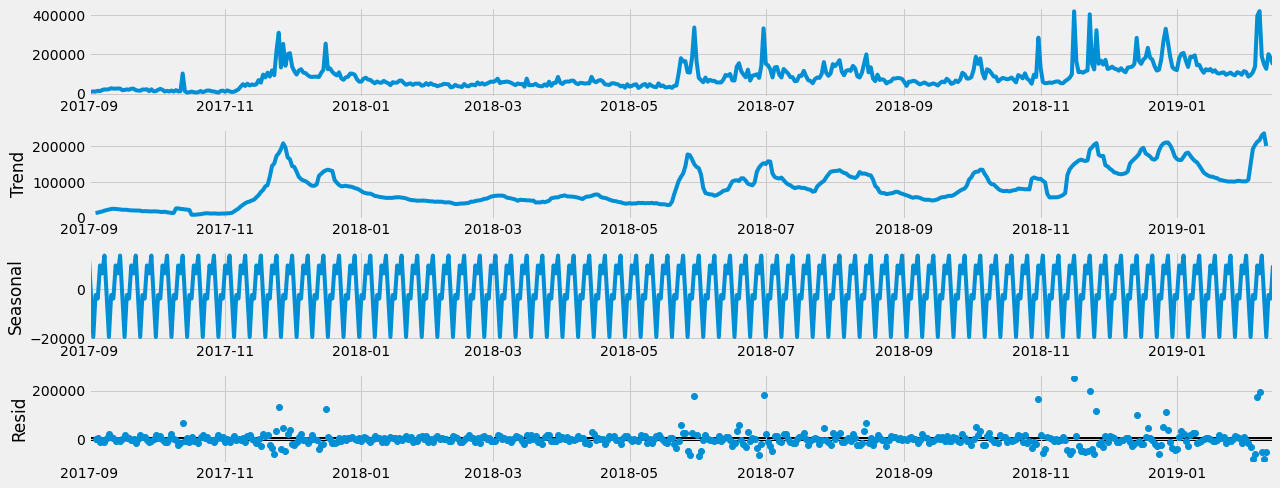

In [12]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The trend line differs from the level indicating that there are fluctuations and noise in the data set as it is not smoothed.  
#### There are some noisy periods in the data, namely November and December 2018 which is probably due to Black Friday and Christmas selling periods and would account for the spikes in sales seen in the trend line.  
#### There is also noise in June and July which could be driven by the release of the Air Jordan 1 Off White University Blue (23/06/2018) which was a highly coveted sneaker.
#### It looks like without these fluctuations due to noise the trend line would be pretty flat over the year.
#### There is clear seasonality in the data.  That seems to be on a weekly basis, it could be that the majority of sales are completed over the weekend every week.

### 4. Testing for stationarity

Conduct Dickey Fuller Test to test stationarity of data. A time series needs to be stationary before any forecasts can be applied.
The Dickey Fuller Test will check for the presence of a unit root.  If a unit root is present the data is non-stationary.
Null hypothesis: The data contains a unit root.
Alternative hypothesis:  The data does not contain a unit root.

In [13]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df2['Sale Price'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.654736
p-value                          0.004797
Number of Lags Used              7.000000
Number of Observations Used    523.000000
Critical Value (1%)             -3.442915
Critical Value (5%)             -2.867082
Critical Value (10%)            -2.569722
dtype: float64


##### The p-value is lower than 0.01, a very significant result.  The test statistic is also lesser than the three critical values, meaning we can reject the null hypothesis and say that our data is stationary.

#### However the auto correlation analysis below shows many lines above the confidence interval indicating the data is in fact non stationary.  There is also a lot of seasonality present in the data so these results appear conflicting.

#### This could be a result of the stationarity being weak.  I will go ahead with differencing to try and make the data more stationary.

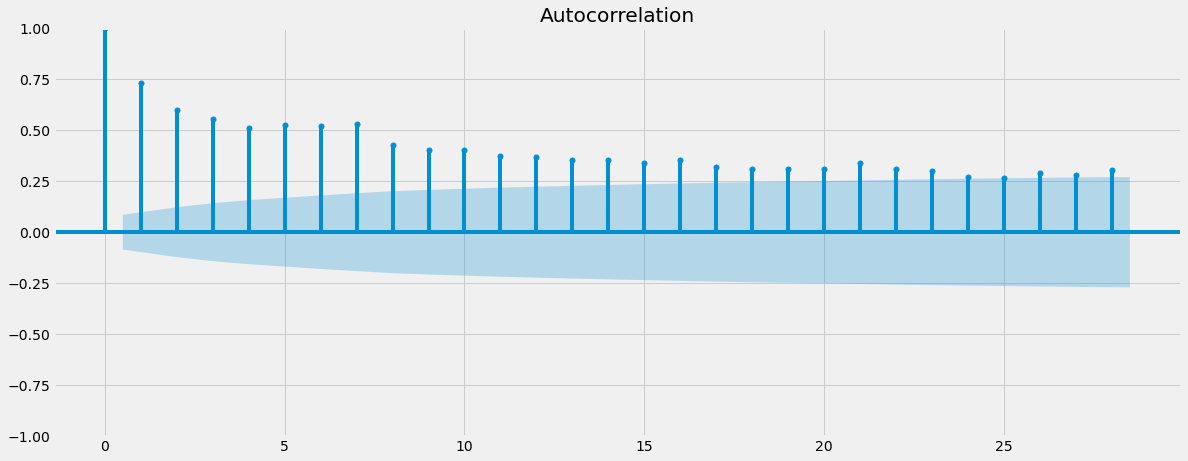

In [14]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df2)
plt.show()

### 5. Stationarising the Data

In [15]:
data_diff = df2 - df2.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [16]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [17]:
data_diff.head()

,Sale Price
,sum
Order Date,
2017-09-02,-5275.0
2017-09-03,1015.0
2017-09-04,-155.0
2017-09-05,3669.0
2017-09-06,-2051.0


In [18]:
data_diff.columns

MultiIndex([('Sale Price', 'sum')],
           )

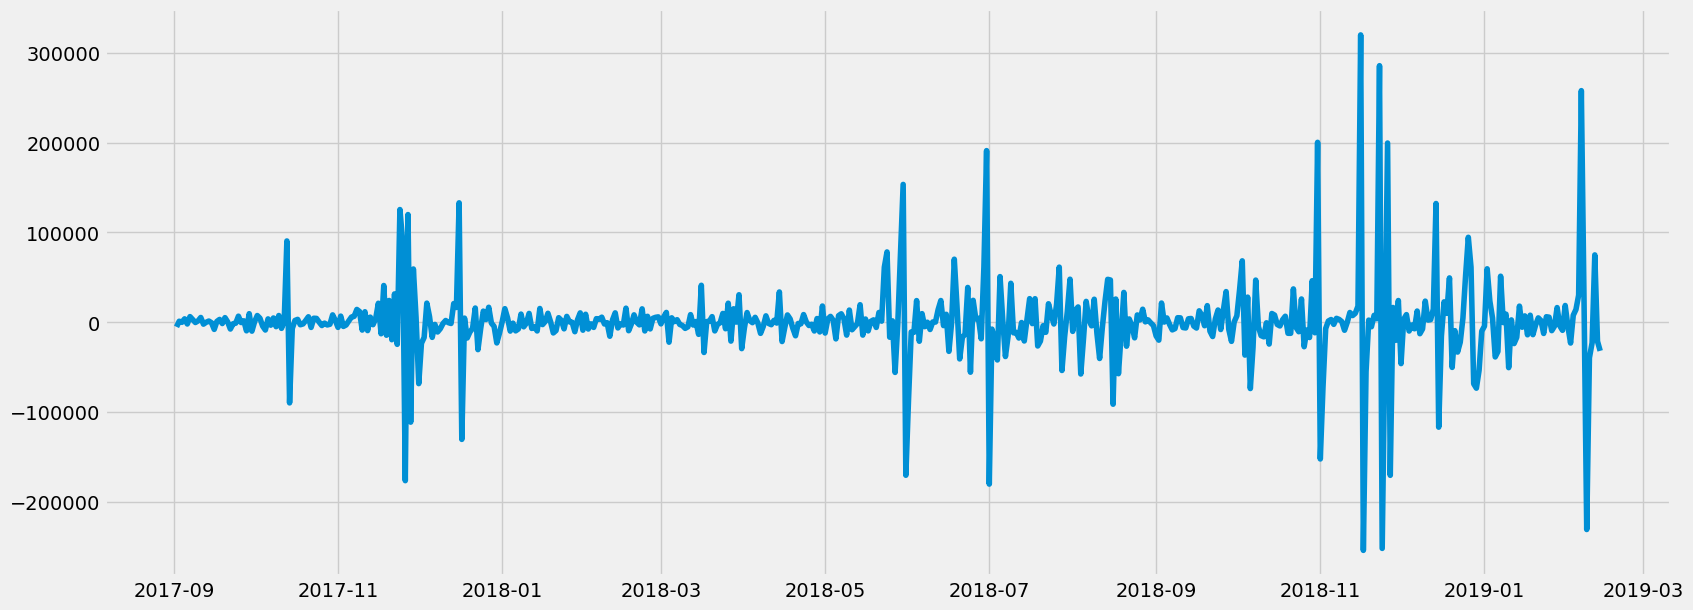

In [19]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(18,7), dpi=100)
plt.plot(data_diff)

In [20]:
# Re-run Dickey Fuller
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.081801e+01
p-value                        1.835941e-19
Number of Lags Used            7.000000e+00
Number of Observations Used    5.220000e+02
Critical Value (1%)           -3.442940e+00
Critical Value (5%)           -2.867093e+00
Critical Value (10%)          -2.569727e+00
dtype: float64


#### This has improved the stationarity of the data and the test statistic is a more negative number at -10.81, again lesser than the three critical values.  This also seems to have reduced the number of lines above the confidence interval in the auto correlation analysis.


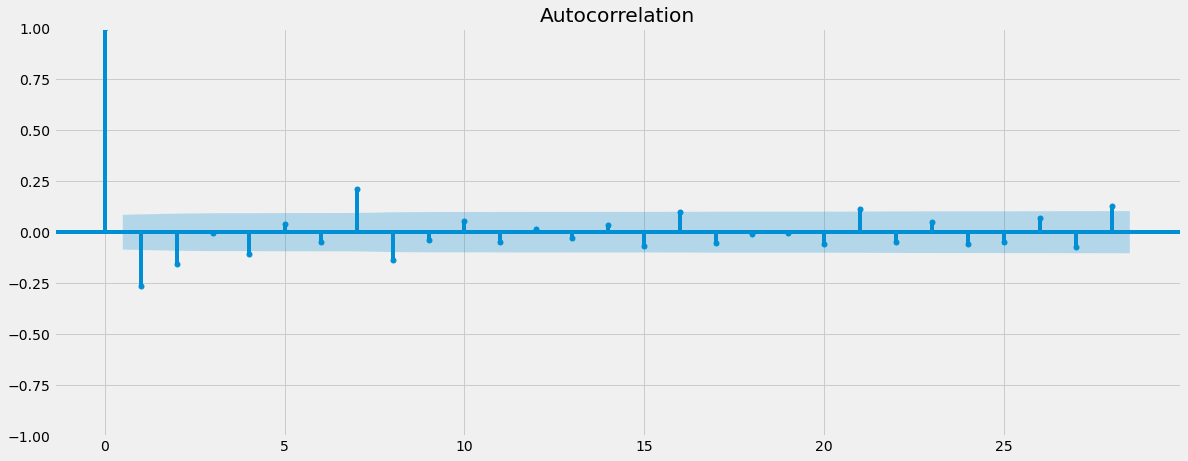

In [21]:
# Re-run auto correlation
plot_acf(data_diff)
plt.show()